In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

import tensorflow_datasets as tfds

## Data Set
We will use this https://www.tensorflow.org/datasets/catalog/food101 this dataset consists of 101 food categories, with 101'000 images. For each class, 250 manually reviewed test images are provided as well as 750 training images. **Hot dog is label 55**


```
@inproceedings{bossard14,
  title = {Food-101 -- Mining Discriminative Components with Random Forests},
  author = {Bossard, Lukas and Guillaumin, Matthieu and Van Gool, Luc},
  booktitle = {European Conference on Computer Vision},
  year = {2014}
}
```

In [2]:
ds, ds_info=tfds.load('food101', shuffle_files=True, as_supervised=True, with_info=True )

In [4]:
train_ds, valid_ds=ds["train"], ds["validation"]

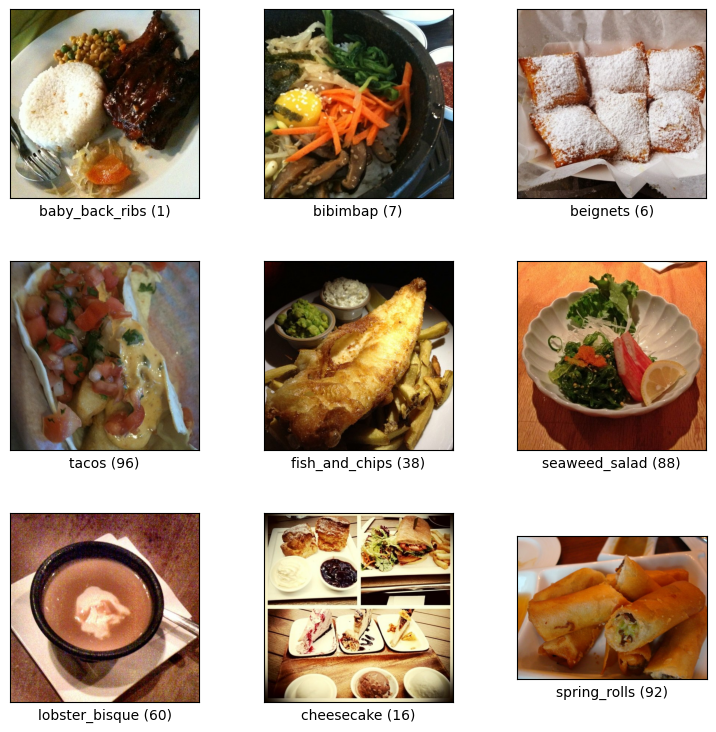

In [5]:
fig=tfds.show_examples(train_ds, ds_info)

In [6]:
#Resize
MAX_SIDE_LEN=128
HOT_DOG_CLASS=55

#This map function can transform our dataset, apply that function (lambda) to every single item in our dataset
train_ds=train_ds.map(
    lambda image, label: (tf.cast(tf.image.resize(image, [MAX_SIDE_LEN, MAX_SIDE_LEN]),dtype=tf.int32), tf.cast(label ==HOT_DOG_CLASS, dtype=tf.int32))

)

valid_ds=valid_ds.map(
    lambda image, label: (tf.cast(tf.image.resize(image, [MAX_SIDE_LEN, MAX_SIDE_LEN]),dtype=tf.int32), tf.cast(label ==HOT_DOG_CLASS, dtype=tf.int32))

)

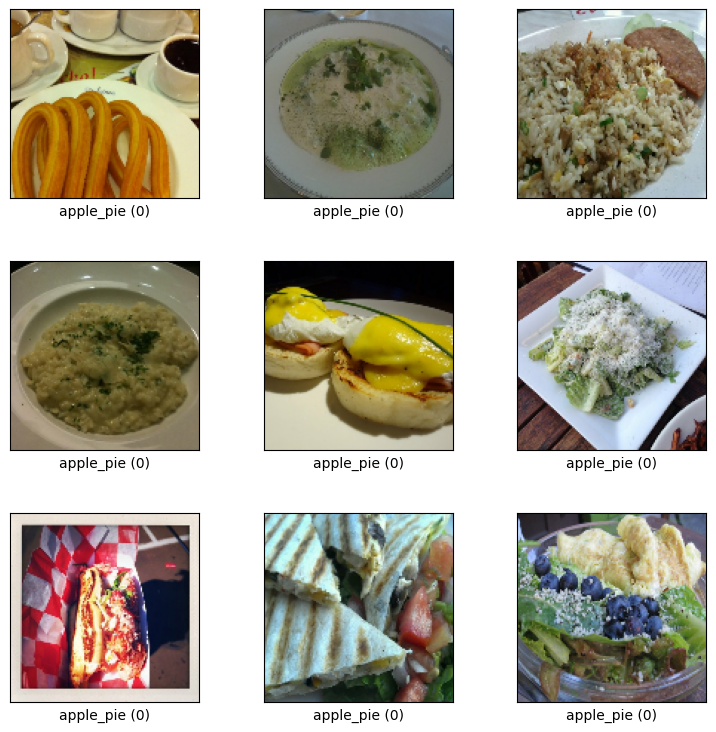

In [7]:
fig=tfds.show_examples(train_ds, ds_info) #resized images and distinguish 0 (apple_pie) for not hot dog and 1 for hot dog

In [8]:
train_hd_size, valid_hd_size=750,250

train_hotdogs=train_ds.filter(lambda image, label: label ==1).repeat(3)
train_nothotdogs=train_ds.filter(lambda image, label: label ==0)

In [9]:
valid_hotdogs=valid_ds.filter(lambda _, label: label ==1).repeat(3)
valid_nothotdogs=valid_ds.filter(lambda _, label: label ==0)

In [10]:
#balance
batch_size=16
train_ds=tf.data.Dataset.sample_from_datasets([train_hotdogs, train_nothotdogs],
                                              weights=[0.5,0.5],
                                              stop_on_empty_dataset=True)

train_ds=train_ds.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE) #cache the dataset somewhere in memory or local store

valid_ds=tf.data.Dataset.sample_from_datasets([valid_hotdogs, valid_nothotdogs], #prefetch overlaps the time that the pre processing of the data is taking place
                                              weights=[0.5,0.5],
                                              stop_on_empty_dataset=True)

valid_ds=valid_ds.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [11]:
#prove that the data is in the format that we want it
for image_batch, label_batch in train_ds.take(1):
    print(image_batch)
    print(label_batch)

tf.Tensor(
[[[[ 70  47  41]
   [145 125 114]
   [174 156 139]
   ...
   [ 48  46  26]
   [194 194 173]
   [190 179 159]]

  [[174 157 141]
   [172 156 140]
   [173 158 139]
   ...
   [149 147 126]
   [194 192 174]
   [190 177 159]]

  [[171 156 133]
   [167 155 132]
   [171 159 140]
   ...
   [192 190 168]
   [192 189 174]
   [186 170 150]]

  ...

  [[165 143 123]
   [176 154 138]
   [197 176 158]
   ...
   [  7   7   7]
   [  6   6   6]
   [  6   6   6]]

  [[165 143 122]
   [198 176 158]
   [203 182 162]
   ...
   [  5   5   5]
   [  6   6   6]
   [  6   6   6]]

  [[173 151 128]
   [199 177 157]
   [187 166 145]
   ...
   [  5   5   5]
   [  5   5   5]
   [  5   5   5]]]


 [[[253 255 254]
   [253 254 253]
   [254 254 252]
   ...
   [254 254 254]
   [255 255 255]
   [255 255 255]]

  [[253 254 253]
   [253 255 254]
   [253 255 254]
   ...
   [252 252 252]
   [253 253 253]
   [255 255 255]]

  [[255 255 253]
   [253 255 254]
   [236 240 241]
   ...
   [ 30  30  30]
   [254 254 254]


# Neural Net implementation

In [24]:
data_augmentation=tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2)])

In [13]:
for i,_ in ds["train"].take(1):
  image=i

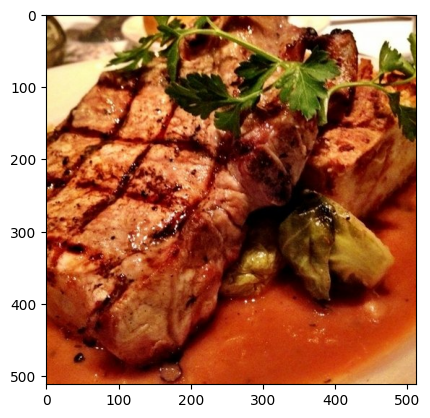

In [14]:
plt.imshow(image)

In [15]:
image=tf.cast(tf.expand_dims(image,0), tf.float32) #I want a list where the only thing in the list is my image
image /=255.0

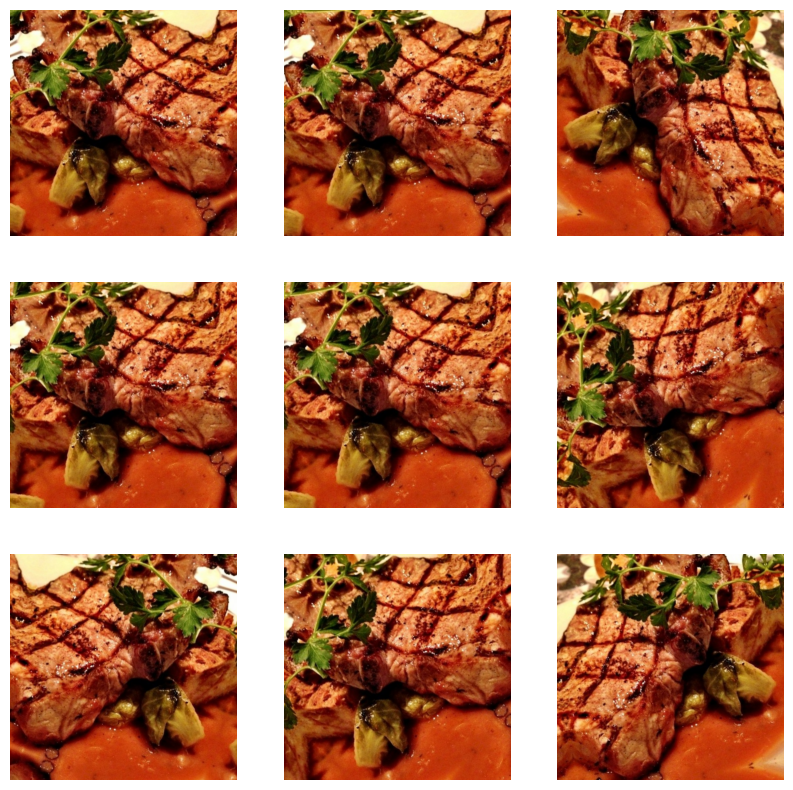

In [16]:
plt.figure(figsize=(10,10))
for i in range(9):
  augmented_image=data_augmentation(image)
  ax=plt.subplot(3,3,i+1)
  plt.imshow(augmented_image[0])
  plt.axis("off")

In [25]:
random.seed(0)
model=models.Sequential()
model.add(layers.Rescaling(1./255))#rescale the images
model.add(data_augmentation)
model.add(layers.Conv2D(64, (3,3), activation='relu', input_shape=[MAX_SIDE_LEN, MAX_SIDE_LEN,3])) #128 different filters and (3,3) is the size of that filter that we are moving across that image
model.add(layers.MaxPooling2D((2,2))) #1
model.add(layers.Dropout(0.25)) #just randomly during the training we're going to turn off 25% of the connections between the layer up 1 and down 2
model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2=0.01)))#2
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Dropout(0.25))
model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2=0.01)))
model.add(layers.Flatten()) #fully connected convolutions
model.add(layers.Dense(128, activation='relu')) #this is a fully connected layer
model.add(layers.Dropout(0.25))
model.add(layers.Dense(1)) #the output is binary we need 1 node

In [27]:
#Adam is a very classic optimizer -> a tool to help us adjust the different weights to go down that gradient towards that minimal loss
lr =0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), #loss known as binary cross entropy because we have only a single output and we're triyin to do binary classification
              metrics=['accuracy'])

In [28]:
epochs=50
history=model.fit(train_ds, epochs=epochs, validation_data=valid_ds, verbose=1)

Epoch 1/50
    291/Unknown 598s 2s/step - accuracy: 0.5134 - loss: 1.5903

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


291/291 ━━━━━━━━━━━━━━━━━━━━ 739s 3s/step - accuracy: 0.5134 - loss: 1.5898 - val_accuracy: 0.4898 - val_loss: 1.1835
Epoch 2/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 251s 864ms/step - accuracy: 0.5173 - loss: 1.1002 - val_accuracy: 0.4898 - val_loss: 0.9340
Epoch 3/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 247s 848ms/step - accuracy: 0.5339 - loss: 0.8938 - val_accuracy: 0.4898 - val_loss: 0.8332
Epoch 4/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 254s 875ms/step - accuracy: 0.5384 - loss: 0.8095 - val_accuracy: 0.4918 - val_loss: 0.7768
Epoch 5/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 265s 887ms/step - accuracy: 0.5540 - loss: 0.7612 - val_accuracy: 0.4959 - val_loss: 0.7420
Epoch 6/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 262s 889ms/step - accuracy: 0.5630 - loss: 0.7305 - val_accuracy: 0.5082 - val_loss: 0.7149
Epoch 7/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 253s 871ms/step - accuracy: 0.5701 - loss: 0.7172 - val_accuracy: 0.5020 - val_loss: 0.7004
Epoch 8/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 263s 905ms/step - accuracy: 0.5788 - loss: 0.6980 

In [29]:
plt.figure(figsize=(10, 10))
for image_batch, label_batch in valid_ds.take(1):
  images = image_batch
  labels = label_batch

<Figure size 1000x1000 with 0 Axes>

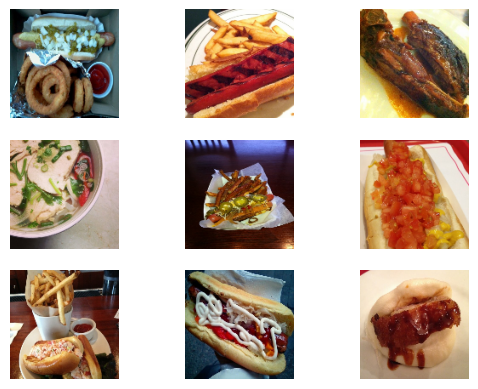

In [30]:
for i in range(9):
  ax = plt.subplot(3, 3, i+1)
  plt.imshow(images[i])
  plt.axis("off")